In [1]:
%matplotlib notebook
import tensorwatch as tw

In [2]:
train = tw.WatcherClient(port=0)
test = tw.WatcherClient(port=1)

<IPython.core.display.Javascript object>


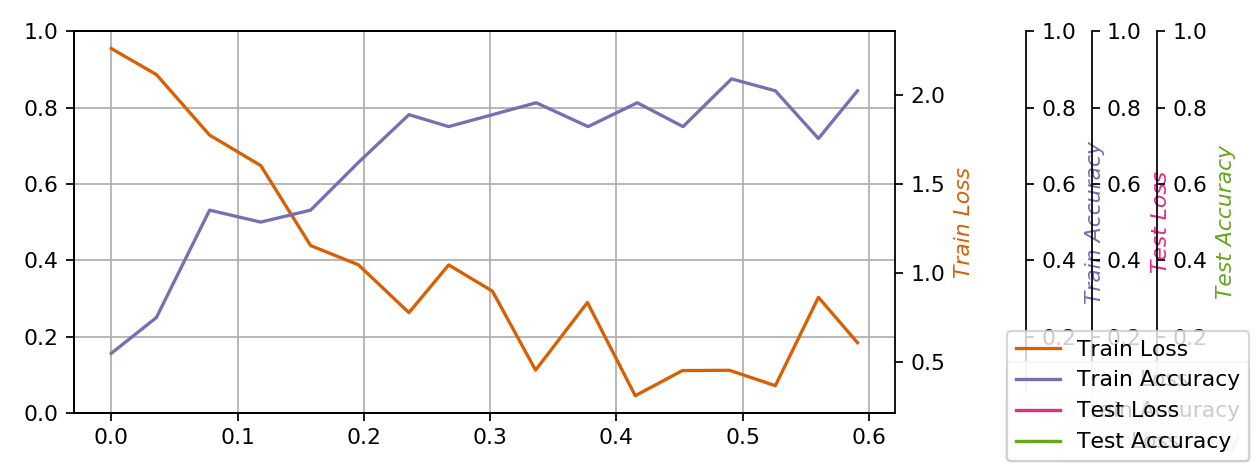

In [3]:
loss_stream = train.create_stream(expr='lambda d:(d.x, d.metrics.batch_loss)', event_name='batch')
loss_plot = tw.Visualizer(loss_stream, vis_type='line', 
                          xtitle='Epoch', ytitle='Train Loss')
loss_plot.show()

In [4]:
acc_stream = train.create_stream(expr='lambda d:(d.x, d.metrics.batch_accuracy)', event_name='batch')
acc_plot = tw.Visualizer(acc_stream, vis_type='line', host=loss_plot,
                          xtitle='Epoch', ytitle='Train Accuracy', yrange=(0,))
acc_plot.show()

In [5]:
test_loss_stream = test.create_stream(expr='lambda d:(d.x, d.metrics.batch_loss)', event_name='batch')
test_loss_plot = tw.Visualizer(test_loss_stream, vis_type='line', host=loss_plot,
                               xtitle='Epoch', ytitle='Test Loss', yrange=(0,))
test_loss_plot.show()

In [6]:
test_acc_stream = test.create_stream(expr='lambda d:(d.x, d.metrics.batch_accuracy)', event_name='batch')
test_acc_plot = tw.Visualizer(test_acc_stream, vis_type='line', host=loss_plot,
                              xtitle='Epoch', ytitle='Test Accuracy', yrange=(0,))
test_acc_plot.show()

<IPython.core.display.Javascript object>


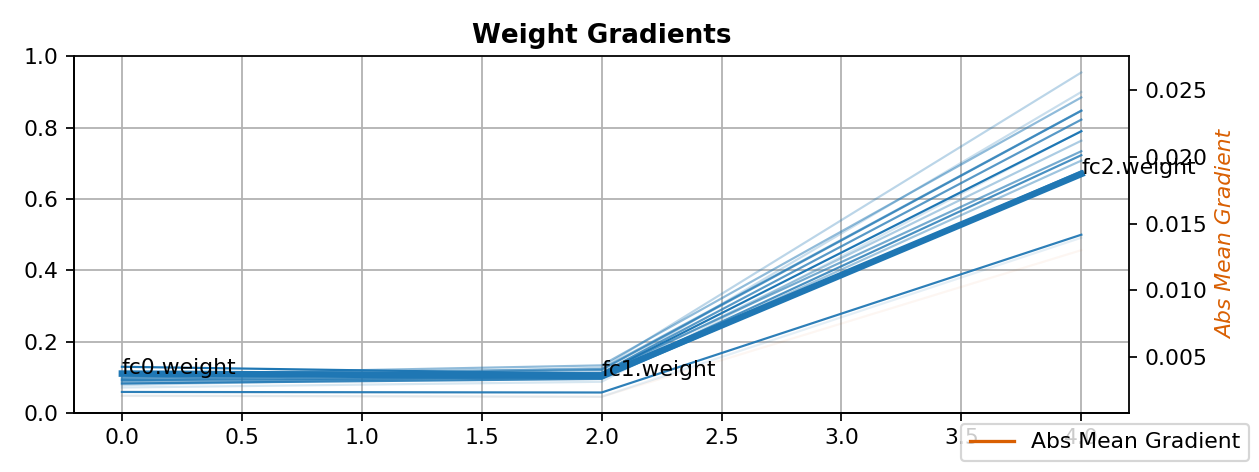

In [7]:
grads_stream = train.create_stream(expr='lambda d:grads_abs_mean(d.model)', 
                                   event_name='batch')
grads_plot = tw.Visualizer(grads_stream, vis_type='line', title="Weight Gradients", clear_after_each=True,
                          xtitle='Layer', ytitle='Abs Mean Gradient', history_len=20)
grads_plot.show()

<IPython.core.display.Javascript object>


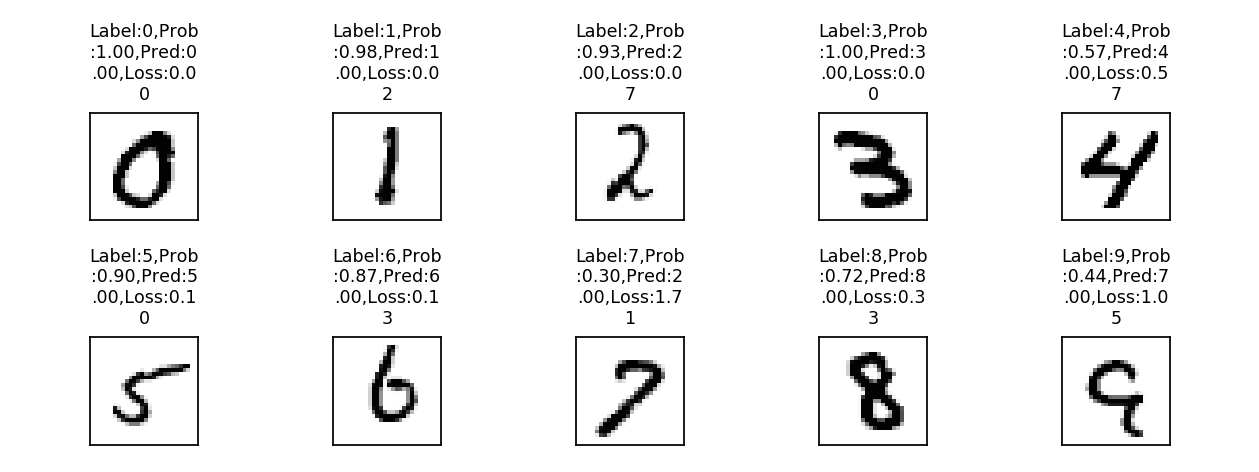

In [8]:
rand_pred = train.create_stream(expr="topk_all(l, \
            batch_vals=lambda b: (b.batch.loss_all, (b.batch.input, b.batch.output), b.batch.target), \
            out_f=image_class_outf, order='rnd')", event_name='batch', throttle=2)
rand_pred_plot = tw.Visualizer(rand_pred, vis_type='image', title="Random Predictions")
rand_pred_plot.show()

<IPython.core.display.Javascript object>


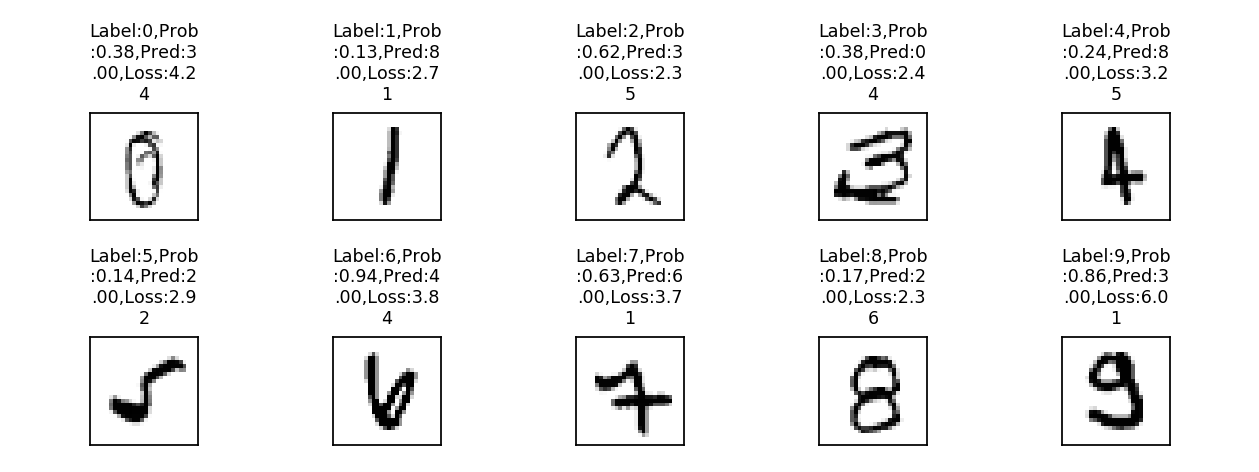

In [9]:
worse_pred = train.create_stream(expr="topk_all(l, \
            batch_vals=lambda b: (b.batch.loss_all, (b.batch.input, b.batch.output), b.batch.target), \
            out_f=image_class_outf, order='dsc')", event_name='batch', throttle=2)
worse_pred_plot = tw.Visualizer(worse_pred, vis_type='image', title="Worst Predictions")
worse_pred_plot.show()